In [1]:
import os 
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from loguru import logger

from models.cluster import KMeansClusterModel

from utils.load import load_sequences
from utils.pitch import extract_pitch_based_features
from utils.pitch import plot_pca_variance
from utils.pitch import plot_clusters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
sequences_df = load_sequences("data/sequences_old")
records = []
for idx, row in sequences_df.iterrows():
        seq = row['sequence']
        features = extract_pitch_based_features(seq, max_interval=12)

        records.append({
            "id": idx,
            "features": features,
            "path": row['path']
        })

features_df = pd.DataFrame(records, index=[r['id'] for r in records])
features_df.head(5)

2025-11-11 20:02:43.150 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences_old with extension .npy
Loading sequences: 323it [00:00, 3651.08it/s]
2025-11-11 20:02:43.276 | SUCCESS  | utils.load:load_sequences:81 - Loaded 323 sequences from data/sequences_old


,id,features,path
bach_2186_vs6_1,bach_2186_vs6_1,"[0.0, 0.13976194237515868, 0.0, 0.182321556793...",data/sequences_old/bach/bach_2186_vs6_1_seq.npy
bach_2191_vs6_5,bach_2191_vs6_5,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",data/sequences_old/bach/bach_2191_vs6_5_seq.npy
bach_2195_fugue3,bach_2195_fugue3,"[0.06136894637629212, 0.13036181786324358, 0.0...",data/sequences_old/bach/bach_2195_fugue3_seq.npy
bach_2196_prelude3,bach_2196_prelude3,"[0.0775582343458745, 0.06252035698133399, 0.01...",data/sequences_old/bach/bach_2196_prelude3_seq...
bach_2198_fugue22,bach_2198_fugue22,"[0.08191712246788672, 0.11506932978478719, 0.0...",data/sequences_old/bach/bach_2198_fugue22_seq.npy


In [4]:
def main():
    sequences_df = load_sequences("data/sequences_old")
    records = []

    for idx, row in sequences_df.iterrows():
        seq = row["sequence"]
        features = extract_pitch_based_features(seq, max_interval=12)

        records.append({
            "id": idx,
            "features": features,
            "path": row["path"]
        })

    # --- Create features dataframe ---
    features_df = pd.DataFrame(records)
    features_df.sort_values("id", inplace=True)
    logger.info(f"Features sample:\n{features_df.head(3)}")

    # --- Stack feature vectors ---
    X = np.vstack(features_df["features"].values)

    # --- Standardize & PCA ---
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_std)

    logger.info(
        f"PCA reduced from {X.shape[1]} → {X_pca.shape[1]} dims "
        f"({pca.explained_variance_ratio_.sum():.2%} variance kept)"
    )
    plot_pca_variance(pca)

    # --- Store transformed features and cluster assignments ---
    features_df["features_transformed"] = [x for x in X_pca]
    
    model = KMeansClusterModel(n_clusters=4, max_iters=300, random_state=42)
    model.fit(X_pca)
    labels = model.labels_

    features_df["cluster"] = labels

    # --- Inspect and plot ---
    logger.info(f"Cluster distribution:\n{features_df['cluster'].value_counts()}")
    plot_clusters(X_pca, labels, dim=3, title="K-Means Clusters on PCA Features")
    
    return features_df


2025-11-11 20:06:58.450 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences_old with extension .npy
Loading sequences: 323it [00:00, 3778.93it/s]
2025-11-11 20:06:58.540 | SUCCESS  | utils.load:load_sequences:81 - Loaded 323 sequences from data/sequences_old
2025-11-11 20:06:59.234 | INFO     | __main__:main:18 - Features sample:
                 id                                           features  \
0   bach_2186_vs6_1  [0.0, 0.13976194237515868, 0.0, 0.182321556793...   
1   bach_2191_vs6_5  [0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...   
2  bach_2195_fugue3  [0.06136894637629212, 0.13036181786324358, 0.0...   

                                               path  
0   data/sequences_old/bach/bach_2186_vs6_1_seq.npy  
1   data/sequences_old/bach/bach_2191_vs6_5_seq.npy  
2  data/sequences_old/bach/bach_2195_fugue3_seq.npy  
2025-11-11 20:06:59.246 | INFO     | __main__:main:30 - PCA reduced from 169 → 89 dims (95.02% variance kept)


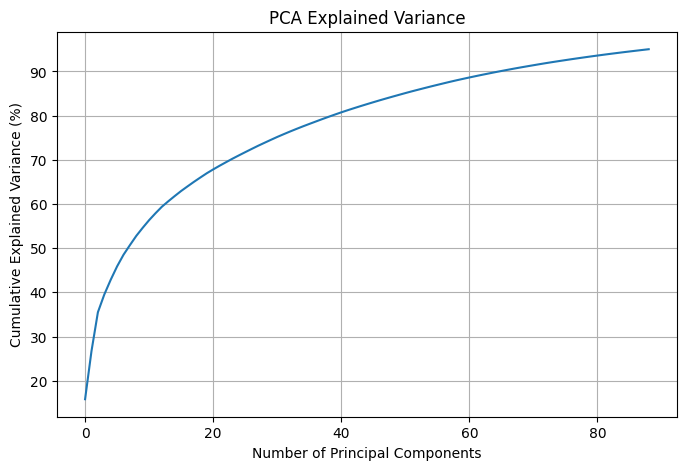

2025-11-11 20:06:59.360 | INFO     | __main__:main:46 - Cluster distribution:
cluster
1    129
3    117
2     54
0     23
Name: count, dtype: int64


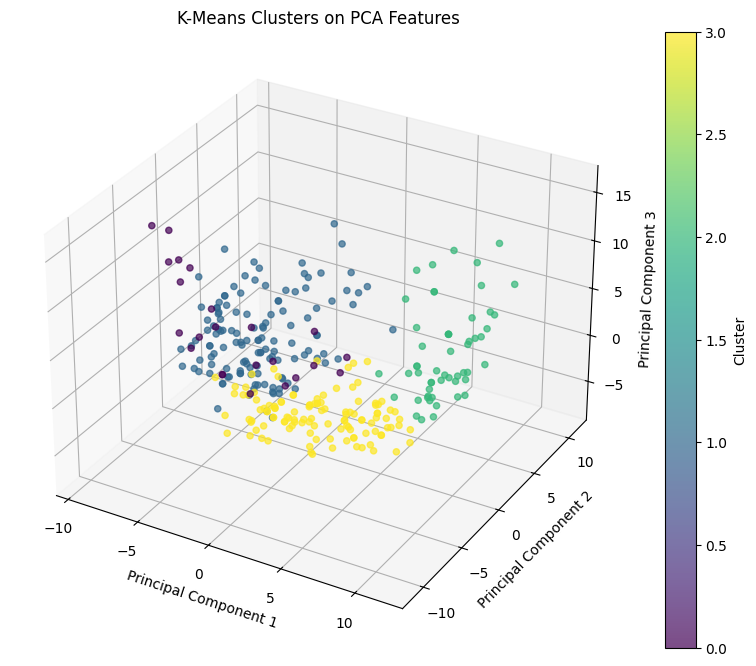

In [5]:
updated_features = main()

In [6]:
updated_features.head(5)

,id,features,path,features_transformed,cluster
0,bach_2186_vs6_1,"[0.0, 0.13976194237515868, 0.0, 0.182321556793...",data/sequences_old/bach/bach_2186_vs6_1_seq.npy,"[10.374165024273584, 7.194099938006979, 8.0201...",2
1,bach_2191_vs6_5,"[0.0, 0.0, 0.0, 0.6931471805599453, 0.0, 0.0, ...",data/sequences_old/bach/bach_2191_vs6_5_seq.npy,"[9.088814621179433, 7.558539716170844, 11.4830...",2
2,bach_2195_fugue3,"[0.06136894637629212, 0.13036181786324358, 0.0...",data/sequences_old/bach/bach_2195_fugue3_seq.npy,"[-4.836732388843908, 7.703081504436189, 3.6135...",1
3,bach_2196_prelude3,"[0.0775582343458745, 0.06252035698133399, 0.01...",data/sequences_old/bach/bach_2196_prelude3_seq...,"[-2.899810051200674, 9.473178215737779, 5.2691...",1
4,bach_2198_fugue22,"[0.08191712246788672, 0.11506932978478719, 0.0...",data/sequences_old/bach/bach_2198_fugue22_seq.npy,"[-3.902279241025601, 6.321395969378976, 3.7973...",1
